# Very Simple Data Wrangling Tutorial

## Overview
We have **2 CSV files**:
- **`country_data.csv`**: Contains population, land area, density, etc.
- **`country_gdp.csv`**: Contains GDP (nominal, 2022), GDP growth, share of world GDP, etc.

We will:
1. **Load** the CSVs.
2. **Clean** them.
3. **Merge** into one dataset.
4. **Create** 5-year population data.
5. **Add** synthetic features (Corruption, HDI, etc.).
6. **Check** correlations.
7. **Handle** outliers.
8. **Compute** a Global Development Score.
9. **FAQ** at the end.

We’ll keep each operation **simple** and **small**. Let’s start!

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from faker import Faker

sns.set(style="whitegrid")
fake = Faker()
print("Libraries loaded!")

Libraries loaded!


## 1. Load the CSV files

In [3]:
# Make sure 'country_data.csv' and 'country_gdp.csv' are in the same folder.
country_data_raw = pd.read_csv("country_data.csv")
country_gdp_raw = pd.read_csv("country_gdp.csv")
print("country_data_raw:")
display(country_data_raw.head(5))

print("\ncountry_gdp_raw:")
display(country_gdp_raw.head(5))

country_data_raw:


,Country,Population (2024),Land Area(Km²),Density(P/Km²)
0,Afghanistan,"42,647,492","652,860",65
1,Albania,"2,791,765","27,400",102
2,Algeria,"46,814,308","2,381,740",20
3,Andorra,"81,938",470,174
4,Angola,"37,885,849","1,246,700",30



country_gdp_raw:


,Country,"GDP (nominal, 2022)",GDP (abbrev.),GDP growth,Population -2022,GDP per capita,Share of World GDP
0,United States,"$25,462,700,000,000",$25.463 trillion,2.06%,"341,534,046","$74,554",25.32%
1,China,"$17,963,200,000,000",$17.963 trillion,2.99%,"1,425,179,569","$12,604",17.86%
2,Japan,"$4,231,140,000,000",$4.231 trillion,1.03%,"124,997,578","$33,850",4.21%
3,Germany,"$4,072,190,000,000",$4.072 trillion,1.79%,"84,086,227","$48,429",4.05%
4,India,"$3,385,090,000,000",$3.385 trillion,7.00%,"1,425,423,212","$2,375",3.37%


## 2. Clean `country_data.csv` (Removing Commas, Convert to Numeric)
We see columns like **`Population (2024)`**, **`Land Area`**, etc. might have commas.
We remove commas and convert to numbers.

In [4]:
country_data = country_data_raw.copy()

# Find columns that likely need cleaning
cols_to_clean = [c for c in country_data.columns if "Population" in c or "Land Area" in c or "Density" in c]

for col in cols_to_clean:
    country_data[col] = country_data[col].astype(str).str.replace(",", "")
    country_data[col] = pd.to_numeric(country_data[col], errors='coerce')

print("After cleaning country_data:")
display(country_data.head(5))

After cleaning country_data:


,Country,Population (2024),Land Area(Km²),Density(P/Km²)
0,Afghanistan,42647492,652860,65
1,Albania,2791765,27400,102
2,Algeria,46814308,2381740,20
3,Andorra,81938,470,174
4,Angola,37885849,1246700,30


### Top 5 by Population (2024) just to check

In [5]:
top5_pop = country_data.sort_values(by="Population (2024)", ascending=False).head(5)
top5_pop

,Country,Population (2024),Land Area(Km²),Density(P/Km²)
77,India,1450935791,2973190,488
36,China,1419321278,9388211,151
186,United States of America,345426571,9147420,38
78,Indonesia,283487931,1811570,156
131,Pakistan,251269164,770880,326


## 3. Clean `country_gdp.csv` (Handle `$`, `%`, etc.)

In [6]:
country_gdp = country_gdp_raw.copy()

def clean_currency(value):
    if isinstance(value, str):
        # remove $, commas, and handle 'trillion', 'billion'
        value = (
            value.replace("$", "")
                 .replace(",", "")
                 .replace(" trillion", "e12")
                 .replace(" billion", "e9")
        )
    try:
        return float(value)
    except:
        return np.nan

### Apply `clean_currency` to GDP columns

In [7]:
if "GDP (nominal, 2022)" in country_gdp.columns:
    country_gdp["GDP (nominal, 2022)"] = country_gdp["GDP (nominal, 2022)"].apply(clean_currency)

if "GDP per capita" in country_gdp.columns:
    country_gdp["GDP per capita"] = country_gdp["GDP per capita"].apply(clean_currency)


### Convert `Share of World GDP` and `GDP growth` from % to decimal

In [8]:
if "Share of World GDP" in country_gdp.columns:
    country_gdp["Share of World GDP"] = (
        country_gdp["Share of World GDP"].str.replace("%", "", regex=False)
    )
    country_gdp["Share of World GDP"] = pd.to_numeric(country_gdp["Share of World GDP"], errors='coerce')
    country_gdp["Share of World GDP"] /= 100.0

if "GDP growth" in country_gdp.columns:
    country_gdp["GDP growth"] = country_gdp["GDP growth"].str.replace("%", "", regex=False)
    country_gdp["GDP growth"] = pd.to_numeric(country_gdp["GDP growth"], errors='coerce')
    country_gdp["GDP growth"] /= 100.0


### Convert `Population -2022` if present

In [9]:
if "Population -2022" in country_gdp.columns:
    country_gdp["Population -2022"] = (
        country_gdp["Population -2022"].astype(str).str.replace(",", "")
    )
    country_gdp["Population -2022"] = pd.to_numeric(country_gdp["Population -2022"], errors='coerce')

print("After cleaning country_gdp:")
display(country_gdp.head(5))

After cleaning country_gdp:


,Country,"GDP (nominal, 2022)",GDP (abbrev.),GDP growth,Population -2022,GDP per capita,Share of World GDP
0,United States,2.546270e+13,$25.463 trillion,0.0206,341534046,74554.0,0.2532
1,China,1.796320e+13,$17.963 trillion,0.0299,1425179569,12604.0,0.1786
2,Japan,4.231140e+12,$4.231 trillion,0.0103,124997578,33850.0,0.0421
3,Germany,4.072190e+12,$4.072 trillion,0.0179,84086227,48429.0,0.0405
4,India,3.385090e+12,$3.385 trillion,0.0700,1425423212,2375.0,0.0337


## 4. Handle Missing Values
- Fill numeric columns in `country_data` with median.
- Drop rows in `country_gdp` missing **`GDP (nominal, 2022)`**.
- Drop columns if more than 50% missing.

In [10]:
print("Missing in country_data:")
display(country_data.isnull().sum())

print("\nMissing in country_gdp:")
display(country_gdp.isnull().sum())

Missing in country_data:


Country              0
Population (2024)    0
Land Area(Km²)       0
Density(P/Km²)       0
dtype: int64


Missing in country_gdp:


Country                0
GDP (nominal, 2022)    0
GDP (abbrev.)          0
GDP growth             0
Population -2022       0
GDP per capita         0
Share of World GDP     0
dtype: int64

### Fill numeric columns in `country_data` with median

In [11]:
num_cols_cd = country_data.select_dtypes(include=[np.number]).columns
for col in num_cols_cd:
    if country_data[col].isnull().sum()>0:
        country_data[col].fillna(country_data[col].median(), inplace=True)


### Drop rows in `country_gdp` missing `GDP (nominal, 2022)`

In [12]:
if "GDP (nominal, 2022)" in country_gdp.columns:
    before = len(country_gdp)
    country_gdp.dropna(subset=["GDP (nominal, 2022)",], inplace=True)
    after = len(country_gdp)
    print(f"Dropped {before - after} rows missing GDP (nominal, 2022)")

Dropped 0 rows missing GDP (nominal, 2022)


### Drop columns in `country_gdp` if >50% missing

In [13]:
for col in country_gdp.columns:
    if country_gdp[col].isnull().mean()>0.5:
        country_gdp.drop(columns=[col], inplace=True)
        print("Dropped column", col)

## 5. Merge the Two Datasets (Outer Join on `Country`)

In [14]:
merged_df = pd.merge(country_data, country_gdp, on="Country", how="outer")
print("Merged dataset info:")
display(merged_df.info())

Merged dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country              207 non-null    object 
 1   Population (2024)    195 non-null    float64
 2   Land Area(Km²)       195 non-null    float64
 3   Density(P/Km²)       195 non-null    float64
 4   GDP (nominal, 2022)  177 non-null    float64
 5   GDP (abbrev.)        177 non-null    object 
 6   GDP growth           177 non-null    float64
 7   Population -2022     177 non-null    float64
 8   GDP per capita       177 non-null    float64
 9   Share of World GDP   177 non-null    float64
dtypes: float64(8), object(2)
memory usage: 16.3+ KB


None

## 6. Generate 5-year Population Data
We’ll create **`Pop_2020`..`Pop_2024`**. If **`Population (2024)`** or **`Population -2022`** is available, use it as a baseline; otherwise random.

In [15]:
def generate_5yr_population(df, start=2020, end=2024):
    for idx, row in df.iterrows():
        pop_2024 = row.get("Population (2024)", np.nan)
        pop_2022 = row.get("Population -2022", np.nan)

        if not pd.isnull(pop_2024):
            base_2024 = pop_2024
        elif not pd.isnull(pop_2022):
            growth_factor = 1 + random.uniform(0.01, 0.03)*(2024-2022)
            base_2024 = pop_2022*growth_factor
        else:
            base_2024 = random.randint(1_000_000,300_000_000)

        # go backwards
        pop_vals = {}
        pop_vals[end] = base_2024
        for year in range(end-1,start-1,-1):
            rev_growth = 1 - random.uniform(0.00,0.03)
            pop_vals[year] = int(pop_vals[year+1]*rev_growth)

        # set columns
        for year in range(start,end+1):
            coln = f'Pop_{year}'
            df.at[idx, coln] = pop_vals[year]
    return df

### Apply it to our merged DataFrame

In [16]:
merged_df = generate_5yr_population(merged_df)
pcols = [f'Pop_{y}' for y in range(2020,2025)]
merged_df[pcols].head(5)

,Pop_2020,Pop_2021,Pop_2022,Pop_2023,Pop_2024
0,40802683.0,41365347.0,41392435.0,41674642.0,42647492.0
1,2617413.0,2645161.0,2654674.0,2729266.0,2791765.0
2,45303961.0,45617580.0,46670810.0,46739691.0,46814308.0
3,79653.0,79852.0,81410.0,81633.0,81938.0
4,34881414.0,35728083.0,36392588.0,37135733.0,37885849.0


## 7. Add Synthetic Features (Corruption, HDI, etc.)
Based on **GDP** and **Population** to look more realistic.

In [17]:
def add_synthetic_features(df):
    for idx, row in df.iterrows():
        gdp = row.get("GDP (nominal, 2022)",0)
        p24 = row.get("Pop_2024",1)

        # tax
        lg = np.log10(gdp+1) if gdp>0 else 0
        tax_est = 5 + (lg-9)*(45/(14-9)) + random.uniform(-2,2)
        tax_est = max(5, min(50,tax_est))

        # corruption => bigger pop => lower index
        pc = min(1_000_000_000,max(1_000_000,p24))
        pop_ratio = (pc-1_000_000)/999_000_000
        base_corr = 100*(1-pop_ratio)
        c_idx = base_corr + random.uniform(-10,10)
        c_idx = max(1, min(100,c_idx))

        # life exp => bigger gdp => bigger
        le_b = 50 + (lg-9)*(35/(14-9)) + random.uniform(-3,3)
        le_b = max(50, min(85, le_b))

        # hdi => 0.3..0.95
        h_b = 0.3+(0.65*((lg-9)/(14-9)))+random.uniform(-0.05,0.05)
        h_b = max(0.3, min(0.95,h_b))

        df.at[idx,"Tax Revenue (%GDP)"] = round(tax_est,2)
        df.at[idx,"Corruption Index"] = round(c_idx,2)
        df.at[idx,"Life Expectancy"] = round(le_b,2)
        df.at[idx,"HDI"] = round(h_b,3)
    return df

### Apply it

In [18]:
merged_df = add_synthetic_features(merged_df)
cols_show = ["Country","GDP (nominal, 2022)","Pop_2024","Tax Revenue (%GDP)","Corruption Index","HDI","Life Expectancy"]
merged_df[cols_show].head(5)

,Country,"GDP (nominal, 2022)",Pop_2024,Tax Revenue (%GDP),Corruption Index,HDI,Life Expectancy
0,Afghanistan,NaN,42647492.0,5.00,100.00,0.300,50.00
1,Albania,1.888210e+10,2791765.0,16.62,100.00,0.440,57.25
2,Algeria,1.919130e+11,46814308.0,25.75,88.73,0.587,68.71
3,Andorra,3.352033e+09,81938.0,9.67,100.00,0.405,50.75
4,Angola,1.067140e+11,37885849.0,21.99,100.00,0.562,62.73


## 8. Plot Correlation Heatmap

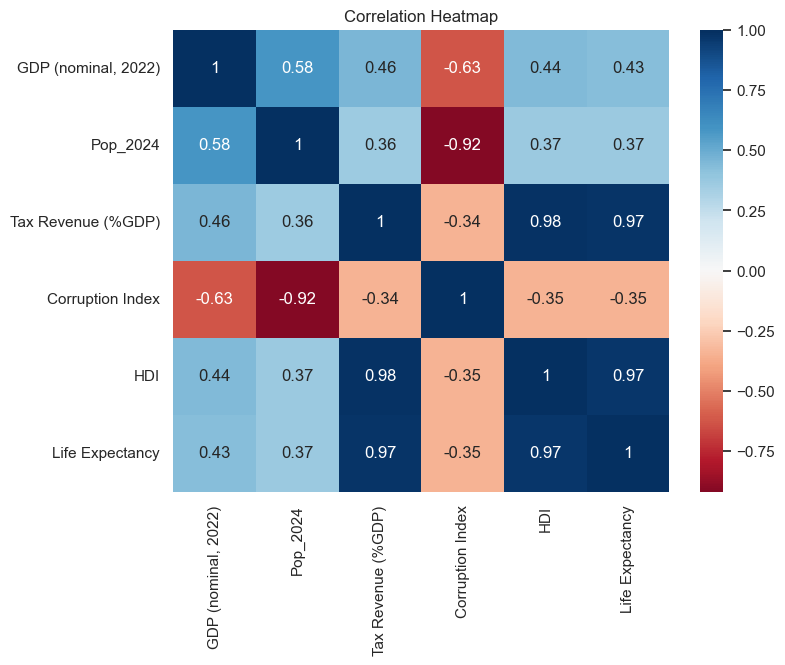

In [19]:
num_cols = ["GDP (nominal, 2022)", "Pop_2024", "Tax Revenue (%GDP)", "Corruption Index", "HDI", "Life Expectancy"]
num_cols = [c for c in num_cols if c in merged_df.columns]
corr_df = merged_df[num_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_df, annot=True, cmap="RdBu", center=0)
plt.title("Correlation Heatmap")
plt.show()

## 9. Wide → Long Conversion (Population) & Plot a Line Chart
### Why?
Some visualizations (like line plots over time) work better when data is in **long format** (one row per `(country, year, population)`).

In [20]:
pcols = [f'Pop_{y}' for y in range(2020,2025)]
idv = [c for c in merged_df.columns if c not in pcols]
pop_long = merged_df.melt(
    id_vars=idv,
    value_vars=pcols,
    var_name="Year",
    value_name="Population"
)
pop_long["Year"] = pop_long["Year"].str.replace("Pop_","").astype(int)
pop_long[['Country','Year','Population']].head(5)

,Country,Year,Population
0,Afghanistan,2020,40802683.0
1,Albania,2020,2617413.0
2,Algeria,2020,45303961.0
3,Andorra,2020,79653.0
4,Angola,2020,34881414.0


### Plot line chart of top 10 populous countries in 2024

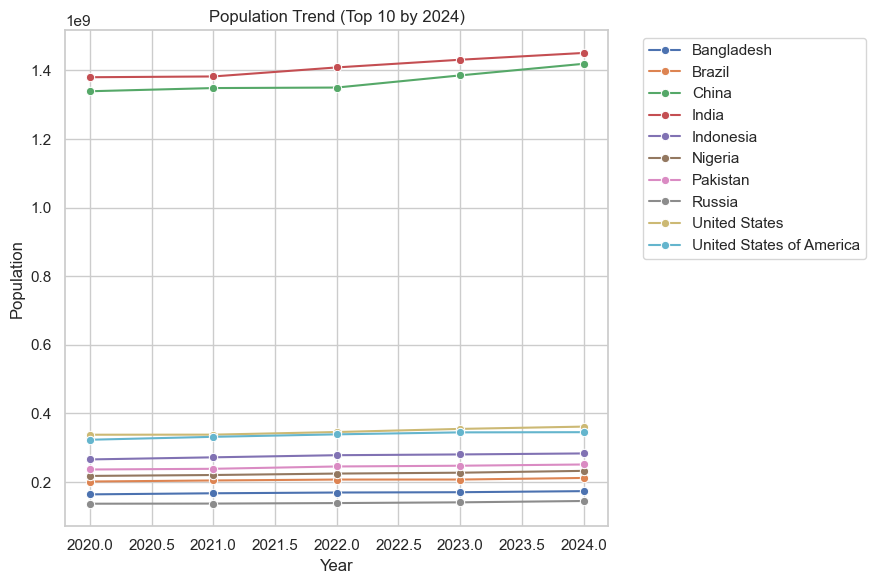

In [21]:
wide_temp = pop_long.pivot(index="Country", columns="Year", values="Population").reset_index()
top_2024 = wide_temp.sort_values(by=2024, ascending=False).head(10)
top_countries = top_2024['Country'].values

pop_plot_df = pop_long[pop_long['Country'].isin(top_countries)]

plt.figure(figsize=(9,6))
sns.lineplot(
    data=pop_plot_df,
    x="Year",
    y="Population",
    hue="Country",
    marker="o"
)
plt.title("Population Trend (Top 10 by 2024)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()

## 10. Handle Outliers (GDP)
We remove extreme outliers in `GDP (nominal, 2022)` using IQR.

In [22]:
filtered_df = merged_df.copy()
if "GDP (nominal, 2022)" in filtered_df.columns:
    Q1 = filtered_df["GDP (nominal, 2022)"].quantile(0.25)
    Q3 = filtered_df["GDP (nominal, 2022)"].quantile(0.75)
    IQR = Q3 - Q1
    cond = (filtered_df["GDP (nominal, 2022)"] >= (Q1-1.5*IQR)) & (filtered_df["GDP (nominal, 2022)"] <= (Q3+1.5*IQR))
    filtered_df = filtered_df[cond]
    print("Outlier filter on GDP done.")
print("Remaining rows:", len(filtered_df))

Outlier filter on GDP done.
Remaining rows: 157


## 11. Create a Global Development Score
### We combine:
- **HDI** (0.3–0.95)
- **Corruption Index** (1–100)
- **Tax Revenue** (5–50)
- **GDP** (log scale)

Weights: 40% HDI, 25% Corruption, 15% log(GDP), 20% Tax.
We do a simple normalization to [0..1].

In [23]:
final_df = filtered_df.copy()

def compute_score(row):
    hdi = row.get("HDI",0)
    corr = row.get("Corruption Index",0)
    gdp = row.get("GDP (nominal, 2022)",0)
    tax = row.get("Tax Revenue (%GDP)",0)

    # HDI => 0.3..0.95 => scale
    nh = (hdi-0.3)/(0.95-0.3)
    nh = min(max(nh,0),1)

    # Corr => 1..100 => scale
    nc = (corr-1)/(99)
    nc = min(max(nc,0),1)

    # GDP => log scale => 9..14 => 0..1
    if gdp>0:
        lg = np.log10(gdp)
        ng = (lg-9)/(14-9)
        ng = min(max(ng,0),1)
    else:
        ng=0

    # tax => 5..50 => 0..1
    nt = (tax-5)/45
    nt = min(max(nt,0),1)

    score = 0.40*nh + 0.25*nc + 0.15*ng + 0.20*nt
    return score

final_df["Global Dev Score"] = final_df.apply(compute_score, axis=1)
final_df[["Country","GDP (nominal, 2022)","Corruption Index","HDI","Tax Revenue (%GDP)","Global Dev Score"]].head(5)

,Country,"GDP (nominal, 2022)",Corruption Index,HDI,Tax Revenue (%GDP),Global Dev Score
1,Albania,1.888210e+10,100.00,0.440,16.62,0.426080
2,Algeria,1.919130e+11,88.73,0.587,25.75,0.558871
3,Andorra,3.352033e+09,100.00,0.405,9.67,0.351130
4,Angola,1.067140e+11,100.00,0.562,21.99,0.547589
5,Antigua and Barbuda,1.757604e+09,100.00,0.312,7.74,0.276910


### Sort Countries by the Score

In [24]:
top10 = final_df.sort_values(by="Global Dev Score", ascending=False).head(10)
top10

,Country,Population (2024),Land Area(Km²),Density(P/Km²),"GDP (nominal, 2022)",GDP (abbrev.),GDP growth,Population -2022,GDP per capita,Share of World GDP,Pop_2020,Pop_2021,Pop_2022,Pop_2023,Pop_2024,Tax Revenue (%GDP),Corruption Index,Life Expectancy,HDI,Global Dev Score
16,Belgium,11738763.0,30280.0,388.0,5.786040e+11,$579 billion,0.0325,11641820.0,49700.0,0.0058,11353783.0,11509267.0,11527683.0,11662121.0,11738763.0,31.15,100.00,68.89,0.700,0.695248
136,Norway,5576660.0,365268.0,15.0,5.792670e+11,$579 billion,0.0328,5456801.0,106155.0,0.0058,5138287.0,5291486.0,5391971.0,5464264.0,5576660.0,29.61,100.00,66.59,0.695,0.685341
179,Sweden,10606999.0,410340.0,26.0,5.859390e+11,$586 billion,0.0264,10487338.0,55871.0,0.0058,10001498.0,10180709.0,10218086.0,10297731.0,10606999.0,31.59,95.60,70.64,0.675,0.670871
195,United Arab Emirates,11027129.0,83600.0,132.0,5.075350e+11,$508 billion,0.0741,10242086.0,49554.0,0.0050,10486418.0,10603458.0,10767268.0,10920650.0,11027129.0,29.20,98.51,70.95,0.675,0.665726
54,Egypt,116538258.0,995450.0,117.0,4.767480e+11,$477 billion,0.0659,112618250.0,4233.0,0.0047,106757669.0,108240946.0,111153374.0,113403472.0,116538258.0,28.89,94.87,70.69,0.689,0.662957
165,Singapore,5832387.0,700.0,8332.0,4.667890e+11,$467 billion,0.0365,5649885.0,82619.0,0.0046,5496642.0,5545007.0,5697389.0,5741407.0,5832387.0,28.07,100.00,70.29,0.649,0.647376
63,Finland,5617310.0,303890.0,18.0,2.808260e+11,$281 billion,0.0208,5569299.0,50424.0,0.0028,5341977.0,5376382.0,5497553.0,5559478.0,5617310.0,27.14,100.00,65.37,0.664,0.645853
86,Ireland,5255017.0,68890.0,76.0,5.292450e+11,$529 billion,0.1197,5110016.0,103570.0,0.0053,4949856.0,5020464.0,5143740.0,5235986.0,5255017.0,29.99,99.99,67.98,0.622,0.640905
184,Thailand,71668011.0,510890.0,140.0,4.953410e+11,$495 billion,0.0259,71735329.0,6905.0,0.0049,67312067.0,67778214.0,67822854.0,69619003.0,71668011.0,28.10,96.84,66.51,0.644,0.637226
144,Peru,34217848.0,1280000.0,27.0,2.426320e+11,$243 billion,0.0268,33475438.0,7248.0,0.0024,33129489.0,33133155.0,33408826.0,33927855.0,34217848.0,28.23,97.63,67.76,0.652,0.635423


### Bar Plot of Top 10

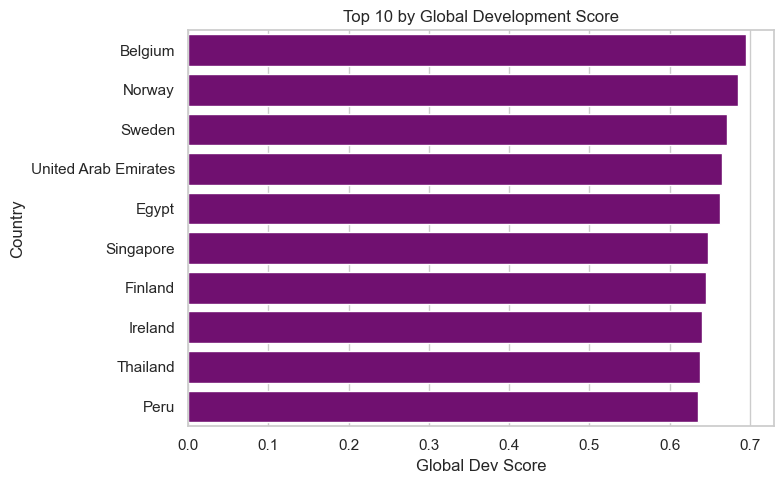

In [25]:
plt.figure(figsize=(8,5))
sns.barplot(x=top10["Global Dev Score"], y=top10["Country"], color="purple")
plt.title("Top 10 by Global Development Score")
plt.xlabel("Global Dev Score")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

## (Optional) Save the Final Data with Synthetic Features & Score

In [26]:
final_df.to_csv("enhanced_country_economic_data.csv", index=False)
print("Saved to enhanced_country_economic_data.csv")

Saved to enhanced_country_economic_data.csv


# Frequently Asked Questions (FAQ)

## Conceptual / Data-Wrangling FAQs
1. **Why do we need to clean the data if it’s only for learning?**  
   Realistic data typically has **inconsistencies** (commas, dollar signs, missing values). Cleaning simulates **real-world** workflows.

2. **Why do we use an outer merge instead of an inner merge?**  
   - **Outer merge** keeps **all countries** from both datasets.  
   - **Inner merge** would only keep **matching** countries.  

3. **What if we want a better method of handling missing values?**  
   - We can use **imputation** (mean, median, or advanced modeling) or simply **drop** if it’s small.

4. **Why do we transform data (wide ↔ long)?**  
   - **Long** format is easier for time-series plotting (like line charts).
   - **Wide** format is better for quick side-by-side comparison.

5. **Why generate synthetic data (Corruption Index, HDI, etc.)?**  
   - If real data is unavailable or confidential, we create **fake** but realistic data.

6. **How did we choose these relationships (GDP => higher tax)?**  
   - They are **simplified** assumptions to make the dataset feel more coherent.

7. **Why use log scale for GDP in the Global Dev Score?**  
   - GDP can vary hugely (millions to trillions). **Log** reduces that range.

8. **Can we change the weights in the Global Dev Score?**  
   - Yes. It’s purely **demonstrative**.

9. **Why use IQR for outlier detection?**  
   - It’s a **simple, robust** method. Others include Z-score, domain rules, etc.

10. **What next after creating a Global Dev Score?**  
   - Further analysis (clustering, correlation, comparing with official indexes, etc.).

## Running / Technical FAQs
1. **FileNotFoundError**: Make sure the CSVs are in the same folder.
2. **ModuleNotFoundError**: Install missing libraries (`pip install faker seaborn`).
3. **Warnings**: Seaborn might have usage changes; typically not breaking.
4. **ValueError** converting strings to numeric: ensure you remove commas before conversion.
5. **Empty plots**: run all previous cells in order.
6. **Wrong Python version**: use Python 3.7+ or 3.9.
7. **KeyError** for `Pop_2024`: maybe the CSV doesn’t have that column spelled the same.
8. **TypeError/ValueError** merging: confirm columns match.
9. **UnicodeDecodeError**: specify correct encoding in `pd.read_csv`.
10. **Save/share**: the final CSV is **`enhanced_country_economic_data.csv`**. Share the `.ipynb` with the CSV files.